In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gmsh
import os
import meshio


In [2]:
# Inicializar Gmsh
gmsh.initialize()

# Abrir archivo .geo
file = "llave.geo"
gmsh.open(file)  # <-- Esta es la clave para cargar la geometría

# Añadir nombre del modelo (opcional si ya está en el archivo)
gmsh.model.setCurrent("llave")

# Sincronizar por si quieres modificar algo en Python
gmsh.model.geo.synchronize()

# Lanzar la interfaz gráfica para visualizar
#gmsh.fltk.run()

# Finalizar Gmsh cuando termines
gmsh.finalize()


Info    : Reading 'llave.geo'...
Info    : Done reading 'llave.geo'


In [3]:
#Establezco el tamaño de la malla
lc = 10

# Inicializar Gmsh
gmsh.initialize()

# Cargar archivo .geo
gmsh.open(file)

# Establecer parámetros de mallado
gmsh.option.setNumber("Mesh.CharacteristicLengthMin", lc)
gmsh.option.setNumber("Mesh.CharacteristicLengthMax", lc)

# Sincronizar (por si hay geometría a modificar, aunque ya fue cargada)
gmsh.model.geo.synchronize()

# Generar la malla (2 = malla 2D, 3 = malla 3D)
gmsh.model.mesh.generate(3)

# Exportar la malla a archivo .msh si lo deseas
output_file = 'malla.msh'
gmsh.write(output_file)

# Visualizar
#gmsh.fltk.run()

gmsh.finalize()

Info    : Reading 'llave.geo'...
Info    : Done reading 'llave.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 101 (Circle)
Info    : [ 10%] Meshing curve 102 (Line)
Info    : [ 10%] Meshing curve 103 (Circle)
Info    : [ 20%] Meshing curve 104 (Line)
Info    : [ 20%] Meshing curve 201 (Circle)
Info    : [ 30%] Meshing curve 202 (Circle)
Info    : [ 30%] Meshing curve 203 (Line)
Info    : [ 30%] Meshing curve 204 (Line)
Info    : [ 40%] Meshing curve 205 (Circle)
Info    : [ 40%] Meshing curve 206 (Circle)
Info    : [ 50%] Meshing curve 207 (Circle)
Info    : [ 50%] Meshing curve 208 (Circle)
Info    : [ 60%] Meshing curve 301 (Line)
Info    : [ 60%] Meshing curve 302 (Line)
Info    : [ 60%] Meshing curve 303 (Circle)
Info    : [ 70%] Meshing curve 304 (Circle)
Info    : [ 70%] Meshing curve 305 (Circle)
Info    : [ 80%] Meshing curve 306 (Line)
Info    : [ 80%] Meshing curve 307 (Line)
Info    : [ 80%] Meshing curve 401 (Line)
Info    : [ 90%] Meshing curve 402 (Line)
Info

In [4]:
import meshio

# Cargar el archivo de malla .msh (versión 4.1 de Gmsh)
mesh = meshio.read(output_file)

for i, (cell_block, phys_ids) in enumerate(zip(mesh.cells, mesh.cell_data["gmsh:physical"])):
    print(f"Block {i} - Tipo: {cell_block.type}, Cantidad: {len(cell_block.data)}, Physical tags: {set(phys_ids)}")



Block 0 - Tipo: line, Cantidad: 2, Physical tags: {5}
Block 1 - Tipo: line, Cantidad: 2, Physical tags: {6}
Block 2 - Tipo: line, Cantidad: 3, Physical tags: {7}
Block 3 - Tipo: triangle, Cantidad: 32, Physical tags: {1}
Block 4 - Tipo: triangle, Cantidad: 77, Physical tags: {2}
Block 5 - Tipo: triangle, Cantidad: 27, Physical tags: {3}
Block 6 - Tipo: triangle, Cantidad: 24, Physical tags: {4}



Grupo Restr Sup - Nodo 17 - Coordenadas (-55.36813052031904, 8.833833256085313)
Grupo Restr Sup - Nodo 64 - Coordenadas (-62.95806526014359, 6.305416628047963)
Grupo Restr Sup - Nodo 64 - Coordenadas (-62.95806526014359, 6.305416628047963)
Grupo Restr Sup - Nodo 15 - Coordenadas (-70.548, 3.777)
Grupo Restr Inf - Nodo 18 - Coordenadas (-49.99306723119177, -7.290355743730593)
Grupo Restr Inf - Nodo 65 - Coordenadas (-57.58253361556887, -9.820177871856291)
Grupo Restr Inf - Nodo 65 - Coordenadas (-57.58253361556887, -9.820177871856291)
Grupo Restr Inf - Nodo 16 - Coordenadas (-65.172, -12.35)


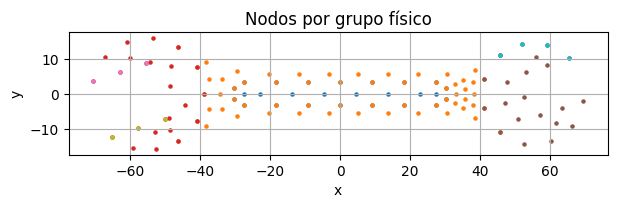

In [5]:
import meshio
from nodes import Node

# Leer archivo .msh
mesh = meshio.read(output_file)

# Asociación de tag físico con nombre
tag_to_name = {v[0]: k for k, v in mesh.field_data.items()}

# Diccionario {nombre_grupo: [Node, Node, ...]}
grupos = {}

# Procesar elementos tipo triangle
for cell_block, phys_tags in zip(mesh.cells, mesh.cell_data["gmsh:physical"]):
    if cell_block.type != "triangle":
        continue
    for tri, tag in zip(cell_block.data, phys_tags):
        nombre = tag_to_name.get(tag, f"{tag}")
        if nombre not in grupos:
            grupos[nombre] = []
        for node_id in tri:
            x, y = mesh.points[node_id][:2]
            grupos[nombre].append(Node(node_id+1, x, y))

# Procesar elementos tipo line (para grupos como "Fuerza")
for cell_block, phys_tags in zip(mesh.cells, mesh.cell_data["gmsh:physical"]):
    if cell_block.type != "line":
        continue
    for line, tag in zip(cell_block.data, phys_tags):
        nombre = tag_to_name.get(tag, f"{tag}")
        if nombre not in grupos:
            grupos[nombre] = []
        for node_id in line:
            x, y = mesh.points[node_id][:2]
            restrain = [0, 0]
            if nombre in ["Restr Sup", "Restr Inf"]:
                print(f"Grupo {nombre} - Nodo {node_id+1} - Coordenadas ({x}, {y})")
                restrain = [1, 1]
            grupos[nombre].append(Node(node_id+1, x, y, restrain=restrain))

           


# Eliminar nodos duplicados por grupo
for nombre in grupos:
    nodos_unicos = {}
    for n in grupos[nombre]:
        nodos_unicos[n.id] = n
    grupos[nombre] = list(nodos_unicos.values())

# Graficar por grupo
Node.plot_nodes_por_grupo(grupos, title='Base', show_ids=False, save=False)


In [6]:
from section import Section

#Ahora creo las 4 secciones posibles
thicknes = {"1": 1.6, "2": 3.0, "3": 5.0, "4": 5.0}
sections = {}

#Defino las propiedades del material

E = 3000
nu = 0.37
rho = 1.25

for group in thicknes:
    sections[group] = Section(thicknes[group], Ex=3000, Ey=1200, nuxy=0.35, Gxy=500)



In [7]:
#Genero un diccionario de nodos para buscarlos por id

nodes_dict = {}
for group in grupos:
    for node in grupos[group]:
        nodes_dict[node.id] = node

In [8]:
from cst import CST

triangles = mesh.cells_dict['triangle']  # nodos por cada triángulo
tags = mesh.cell_data_dict["gmsh:physical"]["triangle"]
elements = []
nodes = set()  # Usamos un set para evitar nodos repetidos

for i in range(len(tags)):
    section = sections[str(tags[i])]

    node_ids = triangles[i]
    print(node_ids)
    nodo_a = nodes_dict[node_ids[0]+1]
    nodo_b = nodes_dict[node_ids[1]+1]
    nodo_c = nodes_dict[node_ids[2]+1]

    print(f"Elemento {i+1} - Sección: {section.thickness} - Nodos: {nodo_a.id}, {nodo_b.id}, {nodo_c.id}")

    for nodo in [nodo_a, nodo_b, nodo_c]:
        nodes.add(nodo)  # Se agregan al set automáticamente sin duplicados

        if np.all(nodo.restrain == [1, 1]):
            print(f"Nodo {nodo.id} con restricción total está en elemento {i+1}, coordenadaa ")
            print(f'las coordenadas son {nodo.x}, {nodo.y}')
            print('')

    elem = CST(i+1, [nodo_a, nodo_b, nodo_c], section)
    elements.append(elem)

nodes = list(nodes)



[ 3 73 75]
Elemento 1 - Sección: 1.6 - Nodos: 4, 74, 76
[ 1 74 76]
Elemento 2 - Sección: 1.6 - Nodos: 2, 75, 77
[73  0 75]
Elemento 3 - Sección: 1.6 - Nodos: 74, 1, 76
[74  2 76]
Elemento 4 - Sección: 1.6 - Nodos: 75, 3, 77
[24 35 73]
Elemento 5 - Sección: 1.6 - Nodos: 25, 36, 74
[31 28 74]
Elemento 6 - Sección: 1.6 - Nodos: 32, 29, 75
[33 26 79]
Elemento 7 - Sección: 1.6 - Nodos: 34, 27, 80
[26 33 80]
Elemento 8 - Sección: 1.6 - Nodos: 27, 34, 81
[35 24 77]
Elemento 9 - Sección: 1.6 - Nodos: 36, 25, 78
[28 31 78]
Elemento 10 - Sección: 1.6 - Nodos: 29, 32, 79
[25 34 77]
Elemento 11 - Sección: 1.6 - Nodos: 26, 35, 78
[32 27 78]
Elemento 12 - Sección: 1.6 - Nodos: 33, 28, 79
[34 25 80]
Elemento 13 - Sección: 1.6 - Nodos: 35, 26, 81
[27 32 79]
Elemento 14 - Sección: 1.6 - Nodos: 28, 33, 80
[22 23 75]
Elemento 15 - Sección: 1.6 - Nodos: 23, 24, 76
[29 30 76]
Elemento 16 - Sección: 1.6 - Nodos: 30, 31, 77
[ 0 22 75]
Elemento 17 - Sección: 1.6 - Nodos: 1, 23, 76
[ 2 29 76]
Elemento 18 - Sec

Nodo fijo: 65
Nodo fijo: 65
Nodo fijo: 16
Nodo fijo: 65
Nodo fijo: 16
Nodo fijo: 65
Nodo fijo: 64
Nodo fijo: 15
Nodo fijo: 64
Nodo fijo: 15
Nodo fijo: 64
Nodo fijo: 64
Nodo fijo: 18
Nodo fijo: 18
Nodo fijo: 18
Nodo fijo: 18
Nodo fijo: 65
Nodo fijo: 18
Nodo fijo: 65
Nodo fijo: 18
Nodo fijo: 17
Nodo fijo: 17
Nodo fijo: 17
Nodo fijo: 17
Nodo fijo: 17
Nodo fijo: 64
Nodo fijo: 17
Nodo fijo: 64


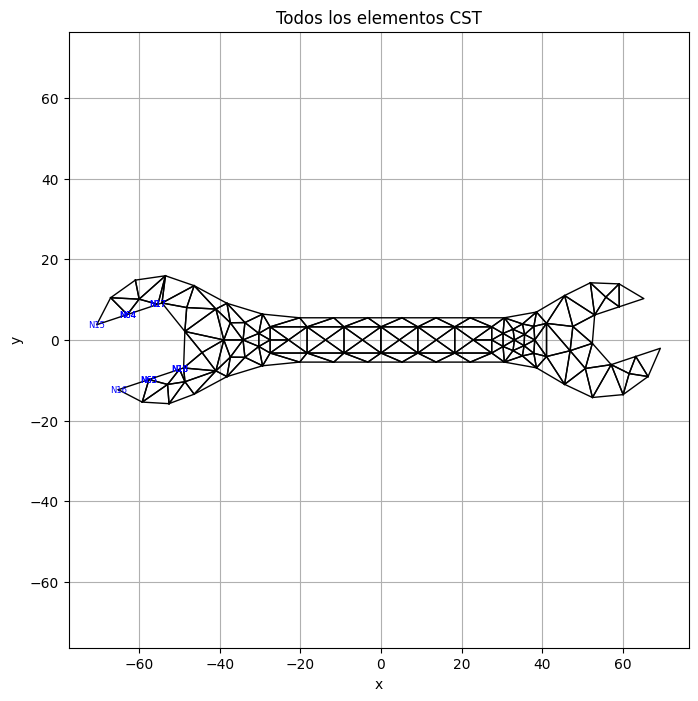

In [9]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import numpy as np

def plot_all_elements(elements, show_ids=True):
    """
    Dibuja todos los elementos CST en una sola figura.

    Parámetros:
    - elements: lista de instancias de CST
    - show_ids: si True, muestra los ID de los nodos y elementos
    """
    plt.figure(figsize=(8, 8))
    
    for elem in elements:
        coords = elem.get_xy_matrix()              # Coordenadas de nodos
        coords = np.vstack([coords, coords[0]])    # cerrar triángulo

        # Diagnóstico: imprimir si algún nodo está completamente restringido
        if np.array_equal(elem.node_list[0].restrain, [1, 1]):
            print(f"Nodo fijo: {elem.node_list[0].id}")
        if np.array_equal(elem.node_list[1].restrain, [1, 1]):
            print(f"Nodo fijo: {elem.node_list[1].id}")
        if np.array_equal(elem.node_list[2].restrain, [1, 1]):
            print(f"Nodo fijo: {elem.node_list[2].id}")



        # Dibujar contorno del triángulo
        plt.plot(coords[:, 0], coords[:, 1], 'k-', linewidth=1)

        # Mostrar ID solo de nodos fijos (con restricción total)
        if show_ids:
            for nodo, (x, y) in zip(elem.node_list, coords[:-1]):
                if np.all(nodo.restrain == [1, 1]):
                    print(f"Nodo fijo: {nodo.id}")
                    plt.text(x, y, f'N{nodo.id}', color='blue', fontsize=6, ha='center', va='center')

    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis('equal')
    plt.grid(True)
    plt.title("Todos los elementos CST")
    plt.show()



plot_all_elements(elements)

In [10]:
from solve import Solve

estructure = Solve(nodes, elements)

In [11]:
import numpy as np

def apply_distributed_force(grupo_nodos, fuerza_total_y, estructura):
    """
    Aplica una fuerza distribuida vertical (por ejemplo, peso) sobre una línea formada por nodos no alineados.
    La fuerza se reparte proporcionalmente a la longitud de los tramos y se descompone en x e y.
    """

    # Paso 1: ordena nodos si es necesario (aquí asumimos que ya están ordenados)
    nodos = grupo_nodos
    n = len(nodos)
    if n < 2:
        print("Se requieren al menos dos nodos para aplicar fuerza distribuida.")
        return

    # Paso 2: calcular longitud total de la línea
    longitudes = []
    total_length = 0
    for i in range(n - 1):
        dx = nodos[i+1].x - nodos[i].x
        dy = nodos[i+1].y - nodos[i].y
        L = np.sqrt(dx**2 + dy**2)
        longitudes.append(L)
        total_length += L

    # Paso 3: calcular carga distribuida por unidad de longitud
    q_total = fuerza_total_y  # Fuerza total a repartir
    q_lineal = q_total / total_length  # N/m

    # Paso 4: aplicar cargas parciales a cada nodo (2 nodos por segmento)
    nodal_forces = {node.id: np.array([0.0, 0.0]) for node in nodos}

    for i in range(n - 1):
        ni = nodos[i]
        nj = nodos[i + 1]
        xi, yi = ni.x, ni.y
        xj, yj = nj.x, nj.y

        dx = xj - xi
        dy = yj - yi
        L = longitudes[i]

        # Dirección normalizada del tramo (unitario)
        vx = dx / L
        vy = dy / L

        # Vector perpendicular (hacia abajo)
        nx = -vy
        ny = vx

        # Fuerza total sobre el tramo
        Fi = q_lineal * L  # Total fuerza sobre el tramo

        # Componente de fuerza en x y y (globales)
        fx = Fi * nx
        fy = Fi * ny

        # Distribuir mitad a cada nodo
        nodal_forces[ni.id] += np.array([fx / 2, fy / 2])
        nodal_forces[nj.id] += np.array([fx / 2, fy / 2])

    # Paso 5: aplicar fuerzas a la estructura
    for node in nodos:
        fx, fy = nodal_forces[node.id]
        dof_x, dof_y = node.dofs
        estructura.apply_force(dof_x, fx)
        estructura.apply_force(dof_y, fy)
        print(f"Nodo {node.id} ← Fx = {fx:.3f} N, Fy = {fy:.3f} N")


In [12]:
# Aplicar -100 N totales sobre línea definida por nodos en grupo "Fuerza"
if "Fuerza" in grupos:
    nodos_fuerza = grupos["Fuerza"]
    apply_distributed_force(nodos_fuerza, fuerza_total_y=100.0, estructura=estructure)


Nodo 22 ← Fx = -8.514 N, Fy = -14.331 N
Nodo 69 ← Fx = -9.162 N, Fy = -30.987 N
Nodo 70 ← Fx = 6.752 N, Fy = -31.585 N
Nodo 11 ← Fx = 7.399 N, Fy = -14.928 N


In [13]:

for element in elements:
    centroid = element.get_centroid()

    area = element.area / 100**2
    espesor = element.section.thickness / 100
    peso = area * espesor * rho * 9.81 

    #Agrego la fuerza al elemento
    F_interna = element.apply_point_body_force(x=centroid[0], y=centroid[1],force_vector=[0, peso])

    for i in range(len(F_interna)):
        F_interna[i] =abs(F_interna[i])*-1

    node_a = element.node_list[0]
    node_b = element.node_list[1]
    node_c = element.node_list[2]

    dof_a = node_a.id * 2
    dof_b = node_b.id * 2
    dof_c = node_c.id * 2

    #Ahora agrego las cargas de peso propio

    estructure.apply_force(dof_index=dof_a, value=F_interna[1])
    estructure.apply_force(dof_index=dof_b, value=F_interna[3])
    estructure.apply_force(dof_index=dof_c, value=F_interna[5])
    

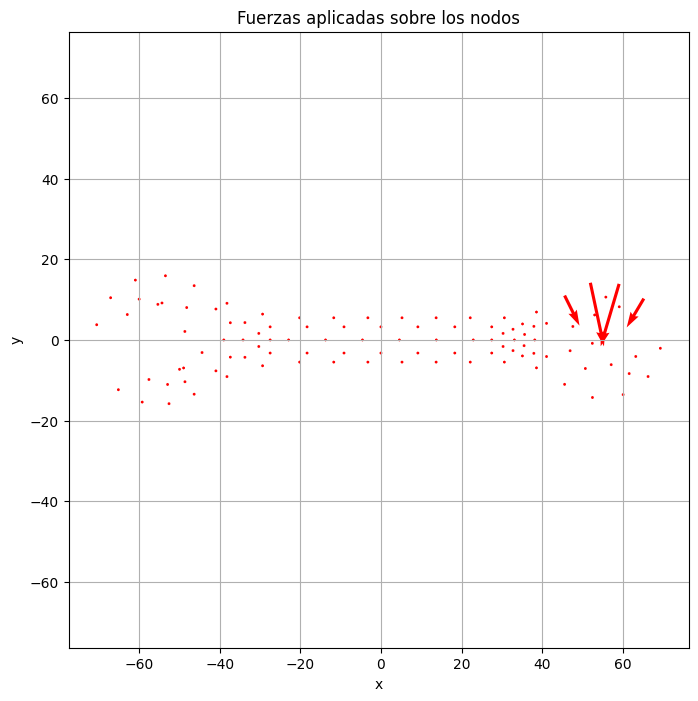

In [14]:
import matplotlib.pyplot as plt

def plot_applied_forces(nodes, f_vector, scale=1e-2):
    """
    Grafica las fuerzas aplicadas en los nodos como flechas (quiver).
    - nodes: lista de nodos
    - f_vector: vector global de fuerzas
    - scale: factor para visualizar flechas
    """
    plt.figure(figsize=(8, 8))
    plt.title("Fuerzas aplicadas sobre los nodos")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis('equal')
    plt.grid(True)

    for node in nodes:
        dof_x, dof_y = node.dofs
        fx = f_vector[dof_x][0] if dof_x < len(f_vector) else 0.0
        fy = f_vector[dof_y][0] if dof_y < len(f_vector) else 0.0

        if not np.isclose(fx, 0.0) or not np.isclose(fy, 0.0):
            plt.quiver(node.x, node.y, fx, fy, angles='xy', scale_units='xy',
                       scale=1/scale, color='red', width=0.005)
            #plt.text(node.x, node.y, f'N{node.id}', fontsize=6, color='black')

    plt.show()

f = estructure.f_original if hasattr(estructure, 'f_original') else estructure.f_global

plot_applied_forces(estructure.nodes, f, scale=0.5)

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def plot_applied_forces(nodes, force_vector, scale=1e-2):
    """
    Dibuja las fuerzas aplicadas en cada nodo como flechas rojas.
    
    Parámetros:
    - nodes: lista de nodos
    - force_vector: vector global de fuerzas (Solve.f_global o Solve.f_original)
    - scale: factor de escala para las flechas
    """
    plt.figure(figsize=(8, 8))
    
    for node in nodes:
        dof_x, dof_y = node.dofs
        fx = force_vector[dof_x, 0] if dof_x < len(force_vector) else 0.0
        fy = force_vector[dof_y, 0] if dof_y < len(force_vector) else 0.0

        if not np.isclose(fx, 0.0) or not np.isclose(fy, 0.0):
            plt.quiver(node.x, node.y, fx, fy, angles='xy', scale_units='xy',
                       scale=1/scale, color='red', width=0.005)
            plt.text(node.x, node.y, f'N{node.id}', fontsize=6, color='black')

    plt.title("Fuerzas aplicadas en nodos")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis('equal')
    plt.grid(True)
    plt.show()



In [16]:
for node in nodes:
    print(f"Nodo {node.id} - Dofs {node.dofs}")

Nodo 102 - Dofs [203 204]
Nodo 43 - Dofs [85 86]
Nodo 14 - Dofs [27 28]
Nodo 3 - Dofs [5 6]
Nodo 34 - Dofs [67 68]
Nodo 101 - Dofs [201 202]
Nodo 68 - Dofs [135 136]
Nodo 103 - Dofs [205 206]
Nodo 98 - Dofs [195 196]
Nodo 105 - Dofs [209 210]
Nodo 38 - Dofs [75 76]
Nodo 17 - Dofs [33 34]
Nodo 7 - Dofs [13 14]
Nodo 62 - Dofs [123 124]
Nodo 64 - Dofs [127 128]
Nodo 15 - Dofs [29 30]
Nodo 18 - Dofs [35 36]
Nodo 13 - Dofs [25 26]
Nodo 65 - Dofs [129 130]
Nodo 61 - Dofs [121 122]
Nodo 16 - Dofs [31 32]
Nodo 22 - Dofs [43 44]
Nodo 27 - Dofs [53 54]
Nodo 30 - Dofs [59 60]
Nodo 69 - Dofs [137 138]
Nodo 1 - Dofs [1 2]
Nodo 82 - Dofs [163 164]
Nodo 100 - Dofs [199 200]
Nodo 94 - Dofs [187 188]
Nodo 70 - Dofs [139 140]
Nodo 2 - Dofs [3 4]
Nodo 11 - Dofs [21 22]
Nodo 4 - Dofs [7 8]
Nodo 31 - Dofs [61 62]
Nodo 28 - Dofs [55 56]
Nodo 5 - Dofs [ 9 10]
Nodo 59 - Dofs [117 118]
Nodo 60 - Dofs [119 120]
Nodo 36 - Dofs [71 72]
Nodo 48 - Dofs [95 96]
Nodo 79 - Dofs [157 158]
Nodo 46 - Dofs [91 92]
Nodo 6 

In [17]:
desplazamientos = estructure.solve()

In [18]:
for nodo in estructure.nodes:
    if np.all(nodo.restrain == [0, 0]):
        ux = estructure.u_global[nodo.dofs[0]][0]
        uy = estructure.u_global[nodo.dofs[1]][0]
        if np.isclose(ux, 0.0) and np.isclose(uy, 0.0):
            print(f"⚠️ Nodo {nodo.id} es libre pero no se mueve: u = ({ux:.2e}, {uy:.2e})")


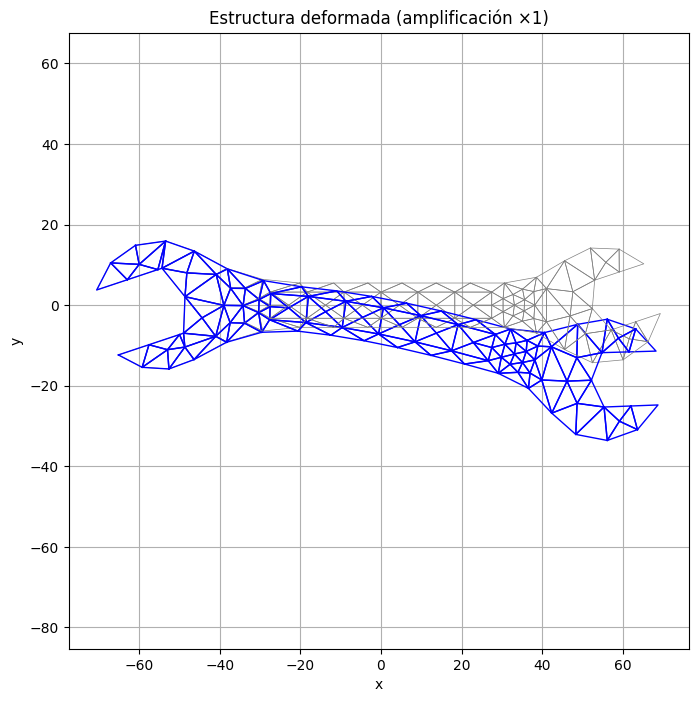

In [19]:
def plot_deformed_structure(elements, scale=1.0, show_ids=False):
    """
    Dibuja estructura original y deformada en el plano XY.

    Parámetros:
    - elements: lista de elementos (tipo CST)
    - scale: factor de amplificación de la deformación
    - show_ids: si True, muestra los IDs de los nodos
    """
    plt.figure(figsize=(8, 8))

    for elem in elements:
        coords = elem.get_xy_matrix()  # shape (3, 2) → [[x1, y1], [x2, y2], [x3, y3]]
        u = np.zeros_like(coords)

        # Obtener desplazamientos globales de cada nodo
        for i, nodo in enumerate(elem.node_list):
            ux = nodo.structure.u_global[nodo.dofs[0], 0]
            uy = nodo.structure.u_global[nodo.dofs[1], 0]
            u[i] = [ux, uy]

        # Dibujar triángulo original
        coords_closed = np.vstack([coords, coords[0]])
        plt.plot(coords_closed[:, 0], coords_closed[:, 1], 'gray', linewidth=0.5)

        # Dibujar triángulo deformado
        def_coords = coords + scale * u
        def_coords_closed = np.vstack([def_coords, def_coords[0]])
        plt.plot(def_coords_closed[:, 0], def_coords_closed[:, 1], 'b', linewidth=1.0)

        if show_ids:
            for i, nodo in enumerate(elem.node_list):
                x, y = def_coords[i]
                plt.text(x, y, str(nodo.id), fontsize=6, color='red')

    plt.title(f"Estructura deformada (amplificación ×{scale})")
    plt.axis('equal')
    plt.grid(True)
    plt.xlabel("x")
    plt.ylabel("y")  # Y como vertical
    plt.show()


# Importante: guardar los desplazamientos en cada nodo
for node in estructure.nodes:
    node.structure = estructure  # para acceder a u_global desde cada nodo

# Luego graficar
plot_deformed_structure(estructure.elements, scale=1, show_ids=False)

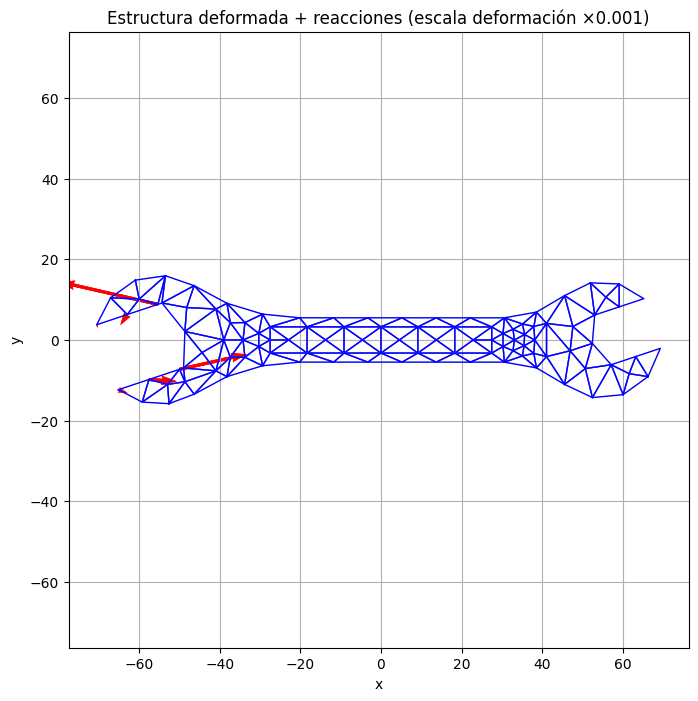

In [20]:
import matplotlib.pyplot as plt
import numpy as np

def plot_deformed_with_reactions(elements, reactions, scale=1.0, reaction_scale=1e-3, show_ids=False):

    plt.figure(figsize=(8, 8))

    for elem in elements:
        coords = elem.get_xy_matrix()
        u = np.zeros_like(coords)

        # Desplazamientos de nodos
        for i, nodo in enumerate(elem.node_list):
            ux = nodo.structure.u_global[nodo.dofs[0], 0]
            uy = nodo.structure.u_global[nodo.dofs[1], 0]
            u[i] = [ux, uy]

        # Triángulo original (gris claro)
        coords_closed = np.vstack([coords, coords[0]])
        plt.plot(coords_closed[:, 0], coords_closed[:, 1], 'lightgray', linewidth=0.5)

        # Triángulo deformado (azul)
        def_coords = coords + scale * u
        def_coords_closed = np.vstack([def_coords, def_coords[0]])
        plt.plot(def_coords_closed[:, 0], def_coords_closed[:, 1], 'b-', linewidth=1.0)

        # Reacciones como flechas en nodos restringidos
        for i, nodo in enumerate(elem.node_list):
            rx = reactions[nodo.dofs[0]][0] if nodo.restrain[0] == 1 else 0.0
            ry = reactions[nodo.dofs[1]][0] if nodo.restrain[1] == 1 else 0.0
            if rx != 0.0 or ry != 0.0:
                plt.quiver(nodo.x, nodo.y, rx, ry, angles='xy', scale_units='xy',
                           scale=1 / reaction_scale, color='red', width=0.005)
            if show_ids:
                x, y = def_coords[i]
                #plt.text(x, y, f'N{nodo.id}', fontsize=6, color='black')

    plt.title(f"Estructura deformada + reacciones (escala deformación ×{scale})")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)
    plt.axis('equal')
    plt.show()

reacciones = estructure.compute_reactions()

plot_deformed_with_reactions(estructure.elements, reacciones, scale=0.001, reaction_scale=0.05, show_ids=True)


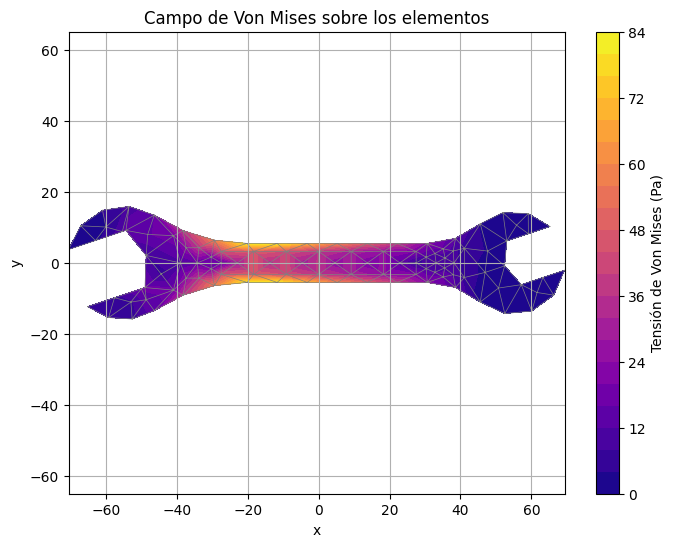

In [21]:
def compute_nodal_von_mises(elements, u_global):
        """
        Promedia los esfuerzos de Von Mises en los nodos a partir de los elementos vecinos.
        """
        nodal_vm = {}  # node.id : [list of vm from attached elements]

        for elem in elements:
            vm = elem.von_mises_stress(u_global)
            for node in elem.node_list:
                if node.id not in nodal_vm:
                    nodal_vm[node.id] = []
                nodal_vm[node.id].append(vm)

        # Promedio por nodo
        nodal_vm_avg = {node_id: np.mean(vms) for node_id, vms in nodal_vm.items()}
        return nodal_vm_avg

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.tri as mtri

def plot_von_mises_field(nodes, elements, vm_nodal_dict, cmap='plasma'):
    """
    Dibuja un campo continuo de Von Mises usando triangulación real de los elementos.
    """
    # Paso 1: generar listas de coordenadas y valores
    node_id_to_index = {}
    xs, ys, vms = [], [], []
    
    for i, node in enumerate(nodes):
        node_id_to_index[node.id] = i
        xs.append(node.x)
        ys.append(node.y)
        vms.append(vm_nodal_dict.get(node.id, 0.0))  # 0 si el nodo no tiene valor

    # Paso 2: conectividad de los elementos
    triangles = []
    for elem in elements:
        triangle = [node_id_to_index[n.id] for n in elem.node_list]
        triangles.append(triangle)

    # Paso 3: crear malla y graficar
    triang = mtri.Triangulation(xs, ys, triangles)

    plt.figure(figsize=(8, 6))
    tcf = plt.tricontourf(triang, vms, levels=20, cmap=cmap)
    plt.triplot(triang, color='gray', linewidth=0.5)  # Opcional: mostrar malla
    plt.colorbar(tcf, label="Tensión de Von Mises (Pa)")
    plt.title("Campo de Von Mises sobre los elementos")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis('equal')
    plt.grid(True)
    plt.show()



vm_nodal = compute_nodal_von_mises(estructure.elements, estructure.u_global)
plot_von_mises_field(estructure.nodes, estructure.elements, vm_nodal)


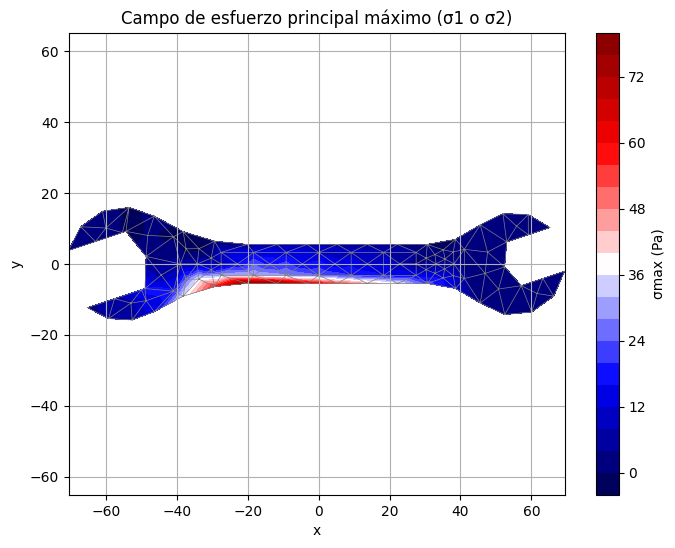

In [22]:
def compute_nodal_sigma1(elements, u_global):
    """
    Devuelve un diccionario {node.id: σ1}, donde σ1 es el mayor esfuerzo principal (con signo).
    """
    nodal_sigmas = {}

    for elem in elements:
        σ1, _ = elem.principal_stresses(u_global)
        for node in elem.node_list:
            if node.id not in nodal_sigmas:
                nodal_sigmas[node.id] = []
            nodal_sigmas[node.id].append(σ1)

    # Promediar por nodo
    nodal_avg = {nid: np.mean(vals) for nid, vals in nodal_sigmas.items()}
    return nodal_avg


def plot_sigma_max_field(nodes, elements, sigma_dict, cmap='seismic'):
    """
    Dibuja el campo escalar de σmax (σ1 o σ2 mayor), permitiendo visualizar compresión y tracción.
    """
    node_id_to_index = {}
    xs, ys, sigmas = [], [], []

    for i, node in enumerate(nodes):
        node_id_to_index[node.id] = i
        xs.append(node.x)
        ys.append(node.y)
        sigmas.append(sigma_dict.get(node.id, 0.0))

    triangles = []
    for elem in elements:
        tri = [node_id_to_index[n.id] for n in elem.node_list]
        triangles.append(tri)

    triang = mtri.Triangulation(xs, ys, triangles)

    plt.figure(figsize=(8, 6))
    tcf = plt.tricontourf(triang, sigmas, levels=20, cmap=cmap)
    plt.triplot(triang, color='gray', linewidth=0.5)
    plt.colorbar(tcf, label="σmax (Pa)")
    plt.title("Campo de esfuerzo principal máximo (σ1 o σ2)")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis('equal')
    plt.grid(True)
    plt.show()

sigma_max_dict = compute_nodal_sigma1(estructure.elements, estructure.u_global)
plot_sigma_max_field(estructure.nodes, estructure.elements, sigma_max_dict)

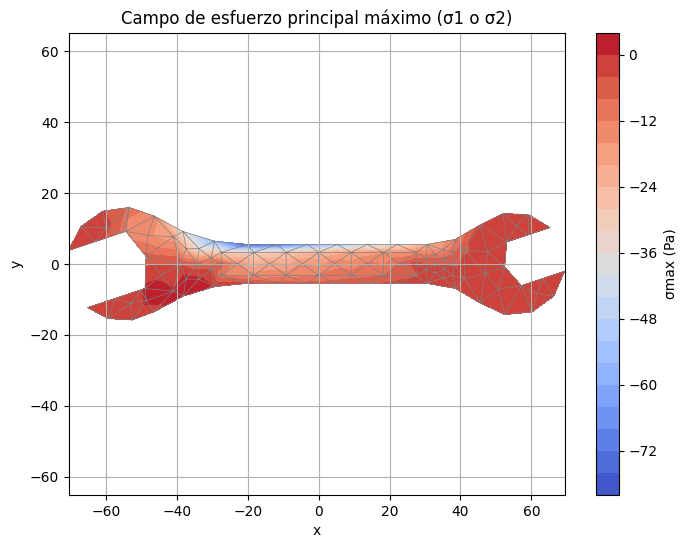

In [23]:
def compute_nodal_sigma2(elements, u_global):
    """
    Devuelve un diccionario {node.id: σ2}, donde σ2 es el menor esfuerzo principal (con signo).
    """
    nodal_sigmas = {}

    for elem in elements:
        _, σ2 = elem.principal_stresses(u_global)
        for node in elem.node_list:
            if node.id not in nodal_sigmas:
                nodal_sigmas[node.id] = []
            nodal_sigmas[node.id].append(σ2)

    # Promediar por nodo
    nodal_avg = {nid: np.mean(vals) for nid, vals in nodal_sigmas.items()}
    return nodal_avg


sigma3_dict = compute_nodal_sigma2(estructure.elements, estructure.u_global)
plot_sigma_max_field(estructure.nodes, estructure.elements, sigma3_dict, cmap='coolwarm')